<a href="https://colab.research.google.com/github/andreadegiorgio/ChatGPT-Detector/blob/main/BERT_embeddings_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets umap-learn hdbscan sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 117.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!cp ./drive/MyDrive/paper_andrea/MG2100_answers_chatgpt.zip ./ && cp ./drive/MyDrive/paper_andrea/MG2100_answers_students.zip ./ && unzip ./MG2100_answers_chatgpt.zip && unzip ./MG2100_answers_students.zip

Archive:  ./MG2100_answers_chatgpt.zip
replace MG2100_answers_chatgpt/answer1_chat1_attempt1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  ./MG2100_answers_students.zip
replace MG2100_answers_students/student1_answer1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from io import BytesIO  # Python 3
import zipfile
from datasets import Dataset, concatenate_datasets
import os
import pandas as pd
from dataclasses import dataclass
import seaborn as sns

In [19]:
import numpy as np

In [44]:
@dataclass
class DataReader():

    filepath:str

    def reader(self):

        out = []
        if os.path.isdir(self.filepath):
            for fi in os.listdir(self.filepath):
                if fi.endswith("txt"):
                    with open(os.path.join(self.filepath,fi),"r") as f:
                        data = f.read()
                    out.append({"path":fi,"text":data})
                    
        else: 
            with open(self.filepath, "r") as f:

                data = f.read()
            out.append({"path":self.filepath,"text":data})
        return out

    def to_datasets(self):

        return Dataset.from_list(self.reader())
    
    def transform_dataset(self, fns, **kwargs):

        for fn in fns:
            self.dataset = self.dataset.map(fn, **kwargs)


class Discovery(object):

    def __init__(self, model):

        self.model = model
    
    def text2embeddings(self):
        pass

    def cosine_sim(self):
        pass
    
    @staticmethod
    def plot_red_embeddings(embeddings, cl, title,**tsne_kwargs):
        
        x_red = TSNE(**tsne_kwargs).fit_transform(embeddings)

        plt.subplots(figsize=(10,10))
        sns.scatterplot(x_red[:,0],x_red[:,1],hue=cl)
        plt.title(title)
        plt.show()


class EmbedderDiscovery(Discovery):

    def __init__(self, model:str):

        super().__init__(model)
        self.model = SentenceTransformer(model)


    def text2embeddings(self, sentences:list, **modelkwargs):

        return self.model.encode(sentences,**modelkwargs)
    
    def cosine_sim(self, v1, v2):

        return cos_sim(v1,v2)

In [45]:
def create_embeddings(batch):
    batch["embeddings"] = embedder.text2embeddings(batch["text"],convert_to_numpy=True)
    return batch

In [49]:
def is_chatgpt(batch):

    batch["is_chatgpt"] = "human" if "student" in batch["path"] else "ChatGPT"
    return batch

In [50]:
stud_data = DataReader("./MG2100_answers_students/").to_datasets()
chatgpt_data = DataReader("./MG2100_answers_chatgpt/").to_datasets()
data = DataReader("")
data.dataset = concatenate_datasets([stud_data,chatgpt_data])
embedder = EmbedderDiscovery("sentence-transformers/all-mpnet-base-v2")
data.transform_dataset([create_embeddings, is_chatgpt])

  0%|          | 0/396 [00:00<?, ?ex/s]

  0%|          | 0/396 [00:00<?, ?ex/s]

In [52]:
embs = np.array(data.dataset["embeddings"])
cl = np.array(data.dataset["is_chatgpt"])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


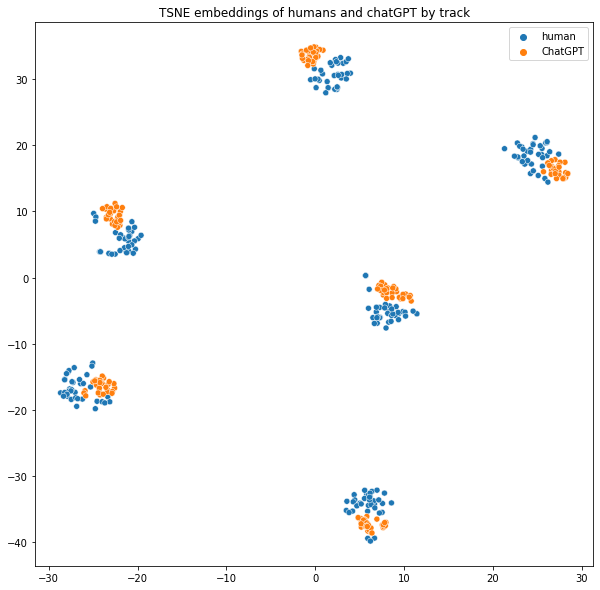

In [53]:
embedder.plot_red_embeddings(embs, cl, title="TSNE embeddings of humans and chatGPT by track")

In [54]:
import re
def sent_len(batch):
    batch["sent_len"] = len(batch['text'].split())
    return batch
def track(batch):
    batch["track"] = re.search("\d",re.search("answer\d",batch["path"])[0])[0]
    return batch

data.transform_dataset([sent_len, track])

  0%|          | 0/396 [00:00<?, ?ex/s]

  0%|          | 0/396 [00:00<?, ?ex/s]

In [55]:
cl = np.array(data.dataset["track"])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


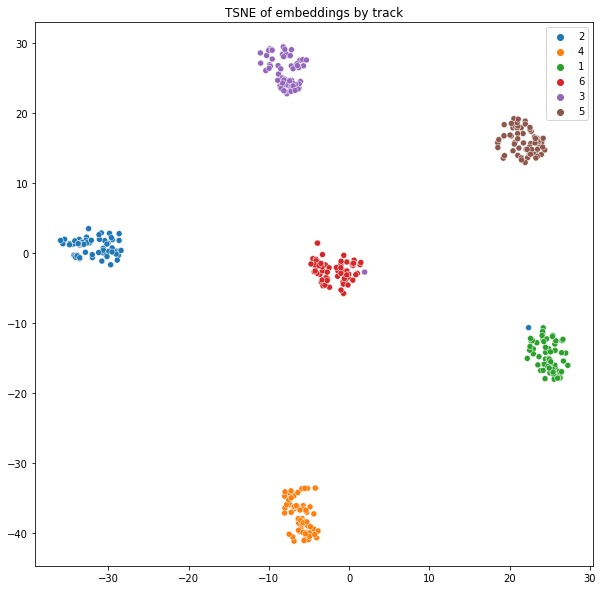

In [56]:
embedder.plot_red_embeddings(embs, cl, title = "TSNE of embeddings by track")

In [35]:
data.dataset[1]

{'path': 'student10_answer2.txt',
 'text': 'Before this course I did not know there was an accepted set of canons and principles for\nengineers to lean on. They are very useful in being separate from law, because there are\nsome principles that, while always should be considered, would not work as a law as ethics\noften boil down to weighing the pros against the cons. There can often be a right or wrong in\na given situation, but it can be very hard to generalise these into laws that should never be\nbroken. For example, the NSPE Rules of Practice state that an engineer should “perform\nservices only in areas of their competence”. But it also states to “hold paramount the safety,\nhealth and welfare of the public”. These two canons will be in conflict if an engineer has the\nopportunity to halt a project that would endanger the public, even though it isn’t his own area\nof expertise. If both of these canons were law, the engineer following canon 1, would be\npunished for breaking canon

In [32]:
from umap import UMAP
from hdbscan import HDBSCAN

In [ ]:
umap = UMAP(n_components=15)
hdb = HDBSCAN()
embs_red = umap.fit_transform(embs)

In [38]:
hdb.fit_predict(embs_red).max()

5